In [1]:
import math
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        # if other is not a Value, assume it is a number and wrap it with a Value
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
        
    
    def __mul__(self, other):
        # if other is not a Value, assume it is a number and wrap it with a Value
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    # int * Value
    def __rmul__(self, other):
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self, ), f'**{other}')
        
        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other): # other - self
        return other + (-self)

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            out._backward = _backward
        return out
    
    def backward(self):
        # build a topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in  visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()


In [2]:
from graphviz import Digraph
def trace(root):
    # Builds a set of all noades and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v  not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is the result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # Connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2, in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

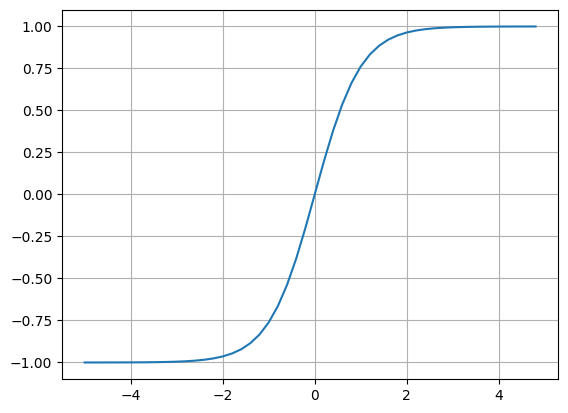

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [4]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w2 + x2*w2'
n = x1w1x2w2 + b; n.label= 'n'
o = n.tanh(); o.label = 'o'

In [5]:
# o.grad = 1.0
# n.grad = 0.5
# x1w1x2w2.grad = 0.5
# b.grad = 0.5
# x1w1.grad = 0.5
# x2w2.grad = 0.5
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

# o.grad = 1.0
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

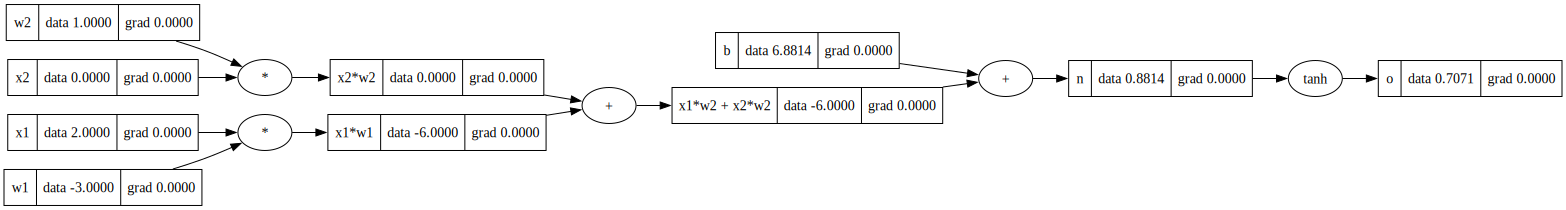

In [6]:
draw_dot(o)

In [7]:
# build a topological graph
# topo = []
# visited = set()
# def build_topo(v):
#     if v not in  visited:
#         visited.add(v)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v)
# build_topo(o)
# topo

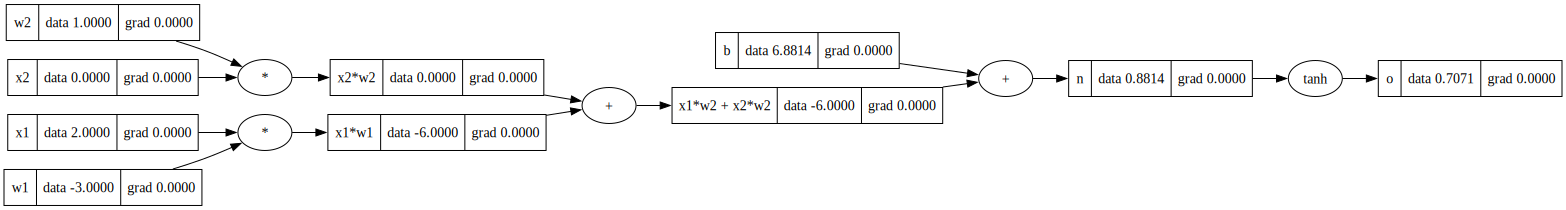

In [8]:
# for node in reversed(topo):
#     node._backward()
draw_dot(o)

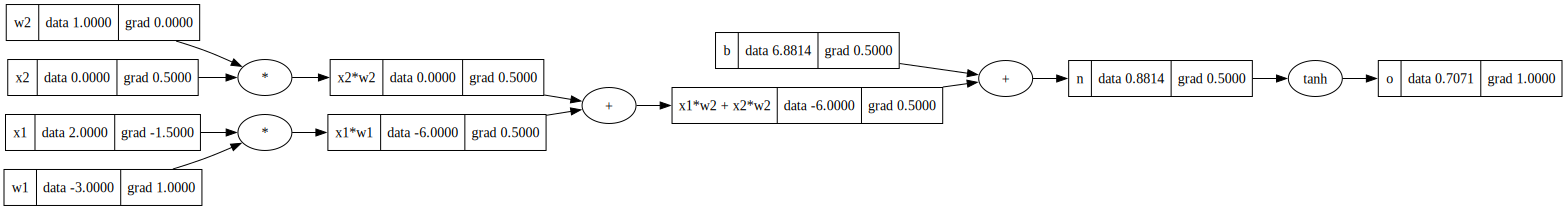

In [9]:
o.backward()
draw_dot(o)

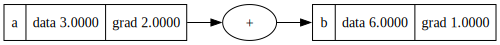

In [10]:
# accummulate the gradients
a = Value(3.0); a.label = 'a'
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [11]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [12]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron b
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w2 + x2*w2'
n = x1w1x2w2 + b; n.label= 'n'

e = (2*n).exp()
o = (e -1) / (e + 1)

o.label = 'o'

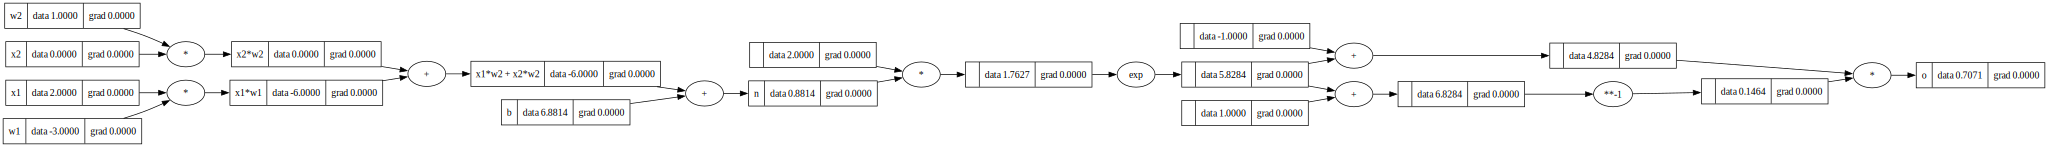

In [13]:
draw_dot(o)

In [14]:
import torch

# double precsion cast
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [22]:
import random
class Neuron:
    # nin: number of inputs
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
        

Value(data=-0.8691667363421813)

In [29]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1,0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8691667363421813),
 Value(data=-0.7930333080217641),
 Value(data=-0.8201162987524018),
 Value(data=-0.8912446064151319)]

In [31]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=7.145783807105357)

In [32]:
loss.backward()

In [34]:
n.layers[0].neurons[0].w[0].grad

-0.015488163382106655

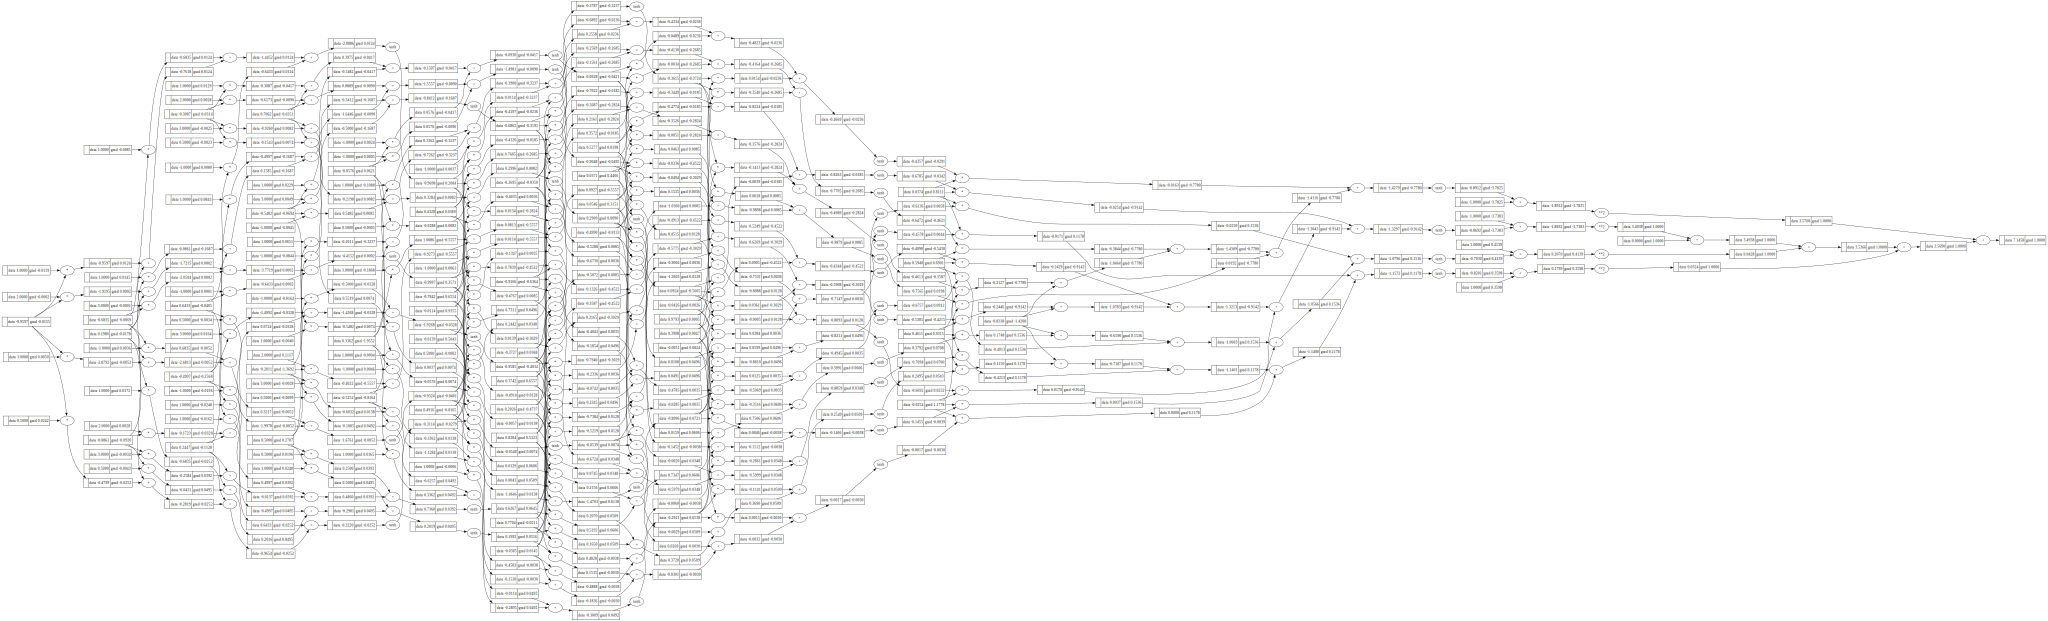

In [35]:
draw_dot(loss)